## 1. Setup Environment & Dependencies

In [1]:
# Check GPU availability
!nvidia-smi

Sat Dec  6 13:47:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install required packages for T4 GPU (Google Colab free tier)
!pip install -q --no-deps xformers trl peft accelerate bitsandbytes
!pip install -q "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install -q datasets pandas matplotlib huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.5/465.5 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 19.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.0/288.0 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 140.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.9/224.9 kB 22.6 MB/s eta 0:00:00


In [3]:
# Import necessary libraries
import json
import os
import time
from datetime import datetime

import pandas as pd
import torch
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from huggingface_hub import notebook_login
from trl import SFTTrainer, SFTConfig
from unsloth import FastLanguageModel

print(f"✅ Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

/tmp/ipython-input-2160001552.py:13: UserWarning: WARNING: Unsloth should be imported before trl, transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
✅ Libraries imported successfully
PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create directory structure in Google Drive
BASE_DIR = '/content/drive/MyDrive/llama3_medical_finetuning'
RAW_DATA_DIR = f'{BASE_DIR}/raw_data'
PROCESSED_DATA_DIR = f'{BASE_DIR}/processed_data'
MODEL_OUTPUT_DIR = f'{BASE_DIR}/model_outputs'
METRICS_DIR = f'{BASE_DIR}/metrics'

os.makedirs(RAW_DATA_DIR, exist_ok=True)
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)

print(f"✅ Google Drive mounted and directories created")
print(f"Base directory: {BASE_DIR}")

Mounted at /content/drive
✅ Google Drive mounted and directories created
Base directory: /content/drive/MyDrive/llama3_medical_finetuning


In [5]:
# Authenticate with HuggingFace Hub
notebook_login()
print(f"✅ HuggingFace authentication complete")

✅ HuggingFace authentication complete


## 2. Data Preprocessing Module

**Note:** Upload your `medical_meadow_wikidoc.csv` and `medquad.csv` files to the `{RAW_DATA_DIR}` folder in Google Drive before running the next cells.

In [6]:
# Configuration for data preprocessing
DATASET_CONFIG = {
    "datasets": [
        f"{RAW_DATA_DIR}/medical_meadow_wikidoc.csv",
        f"{RAW_DATA_DIR}/medquad.csv"
    ],
    "remove_columns": ["source", "focus_area"],
    "rename_columns": {"question": "input", "answer": "output"},
    "instruction": "Answer the question truthfully, you are a medical professional.",
    "use_short_dataset": True,  # Set to False for full dataset (~47K samples)
    "short_dataset_size": 2000  # Use 2000 samples for free Colab T4
}

print(f"Dataset Configuration:")
print(f"  - Using {'SHORT' if DATASET_CONFIG['use_short_dataset'] else 'FULL'} dataset")
if DATASET_CONFIG['use_short_dataset']:
    print(f"  - Sample size: {DATASET_CONFIG['short_dataset_size']}")

Dataset Configuration:
  - Using SHORT dataset
  - Sample size: 2000


In [7]:
# Llama3InstructDataset class for formatting prompts
class Llama3InstructDataset:
    """
    Process raw medical Q&A data into LLaMA-3 instruct format.
    Format: <|start_header_id|>system<|end_header_id|> {instruction}<|eot_id|>
            <|start_header_id|>user<|end_header_id|> {question}<|eot_id|>
            <|start_header_id|>assistant<|end_header_id|> {answer}<|eot_id|>
    """

    def __init__(self, dataset_path: str):
        self.dataset = pd.read_csv(dataset_path)
        print(f"  Loaded {len(self.dataset)} rows from {os.path.basename(dataset_path)}")

    def drop_columns(self, columns: list):
        drop_cols = [col for col in columns if col in self.dataset.columns]
        self.dataset = self.dataset.drop(columns=drop_cols)

    def rename_columns(self, columns: dict):
        self.dataset = self.dataset.rename(columns=columns)

    def create_instruction(self, instruction: str):
        self.dataset["instruction"] = instruction

    def drop_bad_rows(self, columns: list):
        initial_len = len(self.dataset)
        self.dataset = self.dataset.dropna(subset=columns)
        self.dataset = self.dataset.drop_duplicates(subset=columns)
        print(f"  Removed {initial_len - len(self.dataset)} invalid/duplicate rows")

    def create_prompt(self):
        prompts = []
        for _, row in self.dataset.iterrows():
            prompt = (
                f"<|start_header_id|>system<|end_header_id|> {row['instruction']}<|eot_id|>"
                f"<|start_header_id|>user<|end_header_id|> This is the question: {row['input']}<|eot_id|>"
                f"<|start_header_id|>assistant<|end_header_id|> {row['output']}<|eot_id|>"
            )
            prompts.append(prompt)
        self.dataset["text"] = prompts  # TRL expects 'text' column

    def get_dataset(self):
        return self.dataset

print("✅ Llama3InstructDataset class defined")

✅ Llama3InstructDataset class defined


In [8]:
# Process datasets
print("Processing datasets...\n")
all_datasets = []

for dataset_path in DATASET_CONFIG["datasets"]:
    if not os.path.exists(dataset_path):
        print(f"⚠️  WARNING: {os.path.basename(dataset_path)} not found!")
        print(f"   Please upload to: {RAW_DATA_DIR}")
        continue

    print(f"Processing: {os.path.basename(dataset_path)}")
    dataset = Llama3InstructDataset(dataset_path)
    dataset.drop_columns(DATASET_CONFIG["remove_columns"])
    dataset.rename_columns(DATASET_CONFIG["rename_columns"])
    dataset.create_instruction(DATASET_CONFIG["instruction"])
    dataset.drop_bad_rows(["input", "output"])
    dataset.create_prompt()
    all_datasets.append(dataset.get_dataset())
    print(f"  ✅ Processed {len(dataset.get_dataset())} samples\n")

if len(all_datasets) == 0:
    raise FileNotFoundError("No datasets found! Please upload CSV files to Google Drive.")

# Combine all datasets
combined_df = pd.concat(all_datasets, ignore_index=True)
print(f"\n✅ Combined dataset: {len(combined_df)} total samples")

Processing datasets...

Processing: medical_meadow_wikidoc.csv
  Loaded 10000 rows from medical_meadow_wikidoc.csv
  Removed 2 invalid/duplicate rows
  ✅ Processed 9998 samples

Processing: medquad.csv
  Loaded 16412 rows from medquad.csv
  Removed 53 invalid/duplicate rows
  ✅ Processed 16359 samples


✅ Combined dataset: 26357 total samples


In [9]:
# Create short version if configured
if DATASET_CONFIG["use_short_dataset"]:
    # Sample from beginning and end for diversity
    half_size = DATASET_CONFIG["short_dataset_size"] // 2
    combined_df = pd.concat([
        combined_df.iloc[:half_size],
        combined_df.iloc[-half_size:]
    ], ignore_index=True)
    print(f"📊 Using short dataset: {len(combined_df)} samples")
else:
    print(f"📊 Using full dataset: {len(combined_df)} samples")

# Convert to HuggingFace Dataset
combined_df.reset_index(drop=True, inplace=True)
hf_dataset = DatasetDict({"train": Dataset.from_pandas(combined_df[["text"]])})

print(f"\n✅ HuggingFace Dataset created")
print(f"   Features: {hf_dataset['train'].features}")
print(f"   Samples: {len(hf_dataset['train'])}")

📊 Using short dataset: 2000 samples

✅ HuggingFace Dataset created
   Features: {'text': Value('string')}
   Samples: 2000


In [10]:
# Save processed dataset to Google Drive
dataset_name = f"llama3_medical_{'short' if DATASET_CONFIG['use_short_dataset'] else 'full'}"
processed_path = f"{PROCESSED_DATA_DIR}/{dataset_name}"
hf_dataset.save_to_disk(processed_path)
print(f"✅ Dataset saved to: {processed_path}")

# Also save as CSV for inspection
csv_path = f"{PROCESSED_DATA_DIR}/{dataset_name}.csv"
combined_df.to_csv(csv_path, index=False)
print(f"✅ CSV saved to: {csv_path}")

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

✅ Dataset saved to: /content/drive/MyDrive/llama3_medical_finetuning/processed_data/llama3_medical_short
✅ CSV saved to: /content/drive/MyDrive/llama3_medical_finetuning/processed_data/llama3_medical_short.csv


In [11]:
# Display dataset statistics
print("\n" + "="*80)
print("DATASET STATISTICS")
print("="*80)
print(f"Total samples: {len(combined_df)}")
print(f"\nPrompt length statistics (characters):")
prompt_lengths = combined_df['text'].str.len()
print(f"  Mean: {prompt_lengths.mean():.0f}")
print(f"  Median: {prompt_lengths.median():.0f}")
print(f"  Min: {prompt_lengths.min()}")
print(f"  Max: {prompt_lengths.max()}")

print(f"\n{'-'*80}")
print("Sample Prompt (first entry):")
print(f"{'-'*80}")
print(combined_df['text'].iloc[0][:500] + "...\n")


DATASET STATISTICS
Total samples: 2000

Prompt length statistics (characters):
  Mean: 1562
  Median: 993
  Min: 298
  Max: 27451

--------------------------------------------------------------------------------
Sample Prompt (first entry):
--------------------------------------------------------------------------------
<|start_header_id|>system<|end_header_id|> Answer the question truthfully, you are a medical professional.<|eot_id|><|start_header_id|>user<|end_header_id|> This is the question: Can you provide an overview of the lung's squamous cell carcinoma?<|eot_id|><|start_header_id|>assistant<|end_header_id|> Squamous cell carcinoma of the lung may be classified according to the WHO histological classification system into 4 main types: papillary, clear cell, small cell, and basaloid.<|eot_id|>...



## 3. Model Loading & LoRA Configuration

In [29]:
# Model and training configuration
MODEL_CONFIG = {
    "base_model": "unsloth/llama-3-8b-Instruct-bnb-4bit",
    "finetuned_model_name": "llama-3-8b-Instruct-medical",
    # Increased to 4096. Llama-3 handles this easily.
    # If you run out of memory, drop back to 2048.
    "max_seq_length": 4096,
    "dtype": None, # Auto-detect (safer)
    "load_in_4bit": True,
}

LORA_CONFIG = {
    # Increased Rank for better learning capacity
    "r": 64,
    # Rule of thumb: Alpha should be 2x Rank
    "lora_alpha": 128,
    "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj",
                       "gate_proj", "up_proj", "down_proj"],
    "lora_dropout": 0,
    "bias": "none",
    "use_gradient_checkpointing": True,

    # Enable RSLoRA for better stability with higher ranks
    "use_rslora": True,
    "use_dora": False,
}

TRAINING_CONFIG = {
    "per_device_train_batch_size": 2,
    # Increased to 8. Effective batch size = 2 * 8 = 16.
    # This smooths out the learning curve.
    "gradient_accumulation_steps": 8,

    # Use ratio instead of fixed steps for better adaptation
    "warmup_ratio": 0.1,

    # LOWERED from 10. Do not do 10. Start with 3.
    # If it's not smart enough, train for 5. Never 10 for SFT.
    "num_train_epochs": 3,

    # CRITICAL FIX: -1 means "use epochs". 0 means "stop immediately".
    "max_steps": -1,

    "learning_rate": 2e-4,
    "fp16": not torch.cuda.is_bf16_supported(),
    "bf16": torch.cuda.is_bf16_supported(),
    "logging_steps": 1,
    "optim": "adamw_8bit",
    "weight_decay": 0.01,
    "lr_scheduler_type": "linear",
    "seed": 42,
    "output_dir": "/content/outputs",
}

print("✅ Configuration Updated:")
print(f"   Max Seq Length: {MODEL_CONFIG['max_seq_length']}")
print(f"   LoRA Rank/Alpha: {LORA_CONFIG['r']} / {LORA_CONFIG['lora_alpha']}")
print(f"   Effective Batch Size: {TRAINING_CONFIG['per_device_train_batch_size'] * TRAINING_CONFIG['gradient_accumulation_steps']}")
print(f"   Epochs: {TRAINING_CONFIG['num_train_epochs']} (Fixed from 10)")

✅ Configuration Updated:
   Max Seq Length: 4096
   LoRA Rank/Alpha: 64 / 128
   Effective Batch Size: 16
   Epochs: 3 (Fixed from 10)


In [30]:
# Load base model with 4-bit quantization
print("Loading base model...")
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=MODEL_CONFIG["base_model"],
    max_seq_length=MODEL_CONFIG["max_seq_length"],
    dtype=MODEL_CONFIG["dtype"],
    load_in_4bit=MODEL_CONFIG["load_in_4bit"],
)
print(f"✅ Base model loaded: {MODEL_CONFIG['base_model']}")

Loading base model...
==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.57.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
✅ Base model loaded: unsloth/llama-3-8b-Instruct-bnb-4bit


In [31]:
# Apply LoRA/PEFT configuration
print("Applying LoRA configuration...")
model = FastLanguageModel.get_peft_model(
    model,
    r=LORA_CONFIG["r"],
    target_modules=LORA_CONFIG["target_modules"],
    lora_alpha=LORA_CONFIG["lora_alpha"],
    lora_dropout=LORA_CONFIG["lora_dropout"],
    bias=LORA_CONFIG["bias"],
    use_gradient_checkpointing=LORA_CONFIG["use_gradient_checkpointing"],
    random_state=TRAINING_CONFIG["seed"],
    use_rslora=LORA_CONFIG["use_rslora"],
    use_dora=LORA_CONFIG["use_dora"],
)
print(f"✅ LoRA adapters applied (rank={LORA_CONFIG['r']})")

# Display trainable parameters
model.print_trainable_parameters()

Applying LoRA configuration...
✅ LoRA adapters applied (rank=64)
trainable params: 167,772,160 || all params: 8,198,033,408 || trainable%: 2.0465


In [32]:
# Display GPU memory statistics before training
if torch.cuda.is_available():
    gpu_stats = torch.cuda.get_device_properties(0)
    reserved_memory = round(torch.cuda.max_memory_reserved() / 1024**3, 2)
    max_memory = round(gpu_stats.total_memory / 1024**3, 2)

    print("\n" + "="*80)
    print("GPU MEMORY STATISTICS (Before Training)")
    print("="*80)
    print(f"GPU Model: {gpu_stats.name}")
    print(f"Total Memory: {max_memory} GB")
    print(f"Reserved Memory: {reserved_memory} GB")
    print(f"Available Memory: {max_memory - reserved_memory} GB")
    print("="*80 + "\n")


GPU MEMORY STATISTICS (Before Training)
GPU Model: Tesla T4
Total Memory: 14.74 GB
Reserved Memory: 11.68 GB
Available Memory: 3.0600000000000005 GB



## 4. Fine-Tuning with Metrics Tracking

In [35]:
from trl import SFTTrainer, SFTConfig
from transformers import TrainingArguments

# Initialize SFT Trainer
print("Initializing SFTTrainer...")

# --- CONFIGURATION STEP ---
sft_config = SFTConfig(
    dataset_text_field="text",
    max_seq_length=MODEL_CONFIG["max_seq_length"],
    packing=False,

    # Standard Training Arguments
    per_device_train_batch_size=TRAINING_CONFIG["per_device_train_batch_size"],
    gradient_accumulation_steps=TRAINING_CONFIG["gradient_accumulation_steps"],

    # --- UPDATED HERE: Uses warmup_ratio instead of steps ---
    warmup_ratio=TRAINING_CONFIG["warmup_ratio"],
    # -------------------------------------------------------

    max_steps=TRAINING_CONFIG["max_steps"],
    num_train_epochs=TRAINING_CONFIG["num_train_epochs"],
    learning_rate=TRAINING_CONFIG["learning_rate"],
    fp16=TRAINING_CONFIG["fp16"],
    bf16=TRAINING_CONFIG["bf16"],
    logging_steps=TRAINING_CONFIG["logging_steps"],
    optim=TRAINING_CONFIG["optim"],
    weight_decay=TRAINING_CONFIG["weight_decay"],
    lr_scheduler_type=TRAINING_CONFIG["lr_scheduler_type"],
    seed=TRAINING_CONFIG["seed"],
    output_dir=TRAINING_CONFIG["output_dir"],
)

# --- TRAINER INITIALIZATION ---
trainer = SFTTrainer(
    model=model,
    train_dataset=hf_dataset["train"],

    # CRITICAL FIX: TRL v0.24.0+ uses 'processing_class'
    processing_class=tokenizer,

    # Arguments
    args=sft_config
)

print(f"✅ SFTTrainer initialized")
print(f"   Training samples: {len(hf_dataset['train'])}")

# Safe calculation for display
batch_size = TRAINING_CONFIG.get('per_device_train_batch_size', 1)
grad_acc = TRAINING_CONFIG.get('gradient_accumulation_steps', 1)
if batch_size and grad_acc:
    steps_per_epoch = len(hf_dataset['train']) // (batch_size * grad_acc)
    print(f"   Steps per epoch: {steps_per_epoch}")
    print(f"   Total training steps: {steps_per_epoch * TRAINING_CONFIG['num_train_epochs']}")

Initializing SFTTrainer...


Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/2000 [00:00<?, ? examples/s]

✅ SFTTrainer initialized
   Training samples: 2000
   Steps per epoch: 125
   Total training steps: 375


In [36]:
# Train the model
print("\n" + "="*80)
print("STARTING TRAINING")
print("="*80 + "\n")

start_time = time.time()
trainer_stats = trainer.train()
end_time = time.time()

training_time = end_time - start_time
print(f"\n{'='*80}")
print(f"✅ TRAINING COMPLETE")
print(f"{'='*80}")
print(f"Training Time: {training_time/60:.2f} minutes ({training_time:.0f} seconds)")
print(f"{'='*80}\n")

The model is already on multiple devices. Skipping the move to device specified in `args`.



STARTING TRAINING



==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,000 | Num Epochs = 3 | Total steps = 375
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 8 x 1) = 16
 "-____-"     Trainable parameters = 167,772,160 of 8,198,033,408 (2.05% trained)


Step,Training Loss
1,2.907500
2,2.437700
3,2.387300
4,1.937500
5,1.553600
6,1.596700
7,1.794000
8,1.645200
9,1.608900
10,1.556000


train/epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
train/global_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇████
train/grad_norm,█▅▂▂▃▂▂▂▂▂▂▂▆▆▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▂▂▁▂▁▂▁▁▁▁
train/learning_rate,▁▂▂▇████▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▁▁▁▁
train/loss,█▄▄▄▄▄▄▄▄▄▅▄▅▄▃▃▃▃▃▃▃▃▄▃▃▃▂▂▄▁▁▂▁▁▁▁▁▁▁▁
total_flos,1.2528737449736602e+17
train/epoch,3
train/global_step,375
train/grad_norm,1.94733
train/learning_rate,0.0
train/loss,0.2158



✅ TRAINING COMPLETE
Training Time: 140.61 minutes (8437 seconds)



In [37]:
# Display GPU memory statistics after training
if torch.cuda.is_available():
    used_memory = round(torch.cuda.max_memory_allocated() / 1024**3, 2)
    used_memory_training = round(used_memory - reserved_memory, 2)
    used_percentage = round((used_memory / max_memory) * 100, 2)
    training_percentage = round((used_memory_training / max_memory) * 100, 2)

    print("="*80)
    print("GPU MEMORY STATISTICS (After Training)")
    print("="*80)
    print(f"Peak Memory Used: {used_memory} GB ({used_percentage}%)")
    print(f"Memory for Training: {used_memory_training} GB ({training_percentage}%)")
    print(f"Total GPU Memory: {max_memory} GB")
    print("="*80 + "\n")

GPU MEMORY STATISTICS (After Training)
Peak Memory Used: 12.31 GB (83.51%)
Memory for Training: 0.63 GB (4.27%)
Total GPU Memory: 14.74 GB



In [38]:
# Extract and save training metrics
train_loss_history = []
for log in trainer.state.log_history:
    if 'loss' in log:
        train_loss_history.append({
            'step': log.get('step', 0),
            'epoch': log.get('epoch', 0),
            'loss': log['loss'],
            'learning_rate': log.get('learning_rate', 0)
        })

# Convert to DataFrame
loss_df = pd.DataFrame(train_loss_history)

# Save training metrics
loss_csv_path = f"{METRICS_DIR}/training_loss.csv"
loss_df.to_csv(loss_csv_path, index=False)
print(f"✅ Training loss saved to: {loss_csv_path}")

# Save complete trainer stats
stats_json_path = f"{METRICS_DIR}/trainer_stats.json"
with open(stats_json_path, 'w') as f:
    json.dump({
        'training_time_seconds': training_time,
        'training_time_minutes': training_time/60,
        'final_loss': train_loss_history[-1]['loss'] if train_loss_history else None,
        'total_steps': len(train_loss_history),
        'gpu_memory_gb': used_memory,
        'model_config': MODEL_CONFIG,
        'lora_config': LORA_CONFIG,
        'training_config': TRAINING_CONFIG
    }, f, indent=2, default=str)
print(f"✅ Trainer stats saved to: {stats_json_path}")

# Display summary statistics
if len(loss_df) > 0:
    print(f"\nTraining Loss Summary:")
    print(f"  Initial Loss: {loss_df['loss'].iloc[0]:.4f}")
    print(f"  Final Loss: {loss_df['loss'].iloc[-1]:.4f}")
    print(f"  Min Loss: {loss_df['loss'].min():.4f}")
    print(f"  Mean Loss: {loss_df['loss'].mean():.4f}")
    print(f"  Total Steps: {len(loss_df)}")

✅ Training loss saved to: /content/drive/MyDrive/llama3_medical_finetuning/metrics/training_loss.csv
✅ Trainer stats saved to: /content/drive/MyDrive/llama3_medical_finetuning/metrics/trainer_stats.json

Training Loss Summary:
  Initial Loss: 2.9075
  Final Loss: 0.2158
  Min Loss: 0.1944
  Mean Loss: 0.9380
  Total Steps: 375


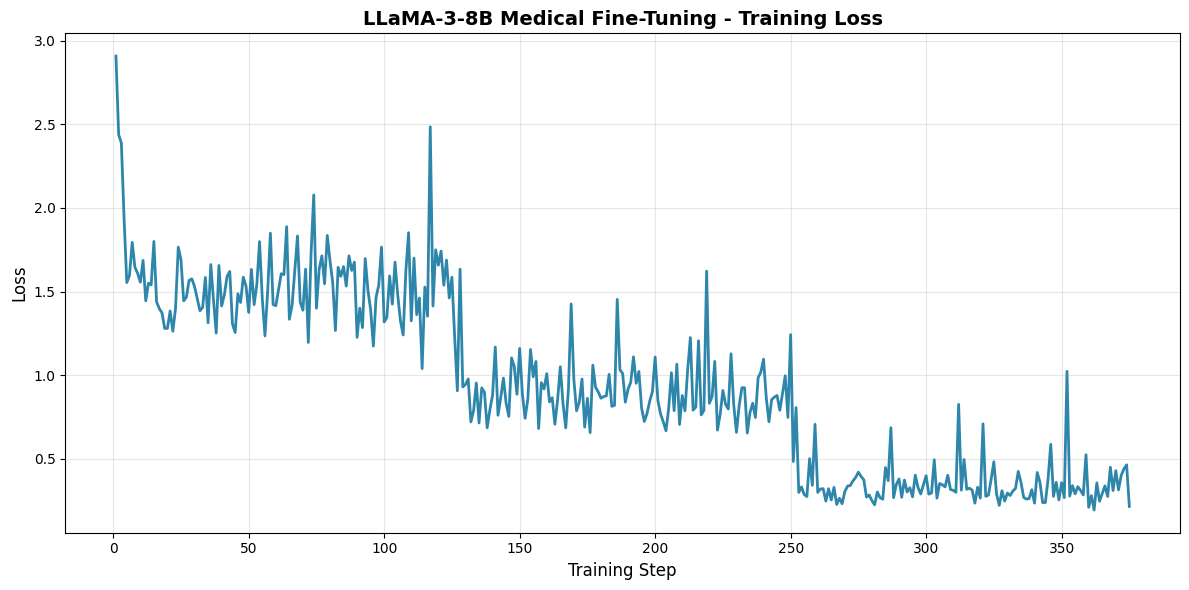

✅ Loss plot saved to: /content/drive/MyDrive/llama3_medical_finetuning/metrics/training_loss.png


In [39]:
# Generate and save training loss plot
if len(loss_df) > 0:
    plt.figure(figsize=(12, 6))
    plt.plot(loss_df['step'], loss_df['loss'], linewidth=2, color='#2E86AB')
    plt.xlabel('Training Step', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('LLaMA-3-8B Medical Fine-Tuning - Training Loss', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plot_path = f"{METRICS_DIR}/training_loss.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Loss plot saved to: {plot_path}")
else:
    print("⚠️  No loss data available to plot")

## 5. Model Saving & Export

In [43]:
# Save LoRA adapters to Google Drive
lora_path = f"{MODEL_OUTPUT_DIR}/lora_adapters"
model.save_pretrained(lora_path)
tokenizer.save_pretrained(lora_path)
print(f"✅ LoRA adapters saved to: {lora_path}")

✅ LoRA adapters saved to: /content/drive/MyDrive/llama3_medical_finetuning/model_outputs/lora_adapters


In [44]:
# Push LoRA adapters to HuggingFace Hub
hf_repo_name = MODEL_CONFIG["finetuned_model_name"]
print(f"Pushing LoRA adapters to HuggingFace Hub: {hf_repo_name}")
model.push_to_hub(hf_repo_name, token=True)
tokenizer.push_to_hub(hf_repo_name, token=True)
print(f"✅ LoRA adapters pushed to: https://huggingface.co/{{your-username}}/{hf_repo_name}")

Pushing LoRA adapters to HuggingFace Hub: llama-3-8b-Instruct-medical


README.md:   0%|          | 0.00/596 [00:00<?, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:   0%|          | 39.3kB /  671MB            

Saved model to https://huggingface.co/llama-3-8b-Instruct-medical


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...mp_kzbg14q/tokenizer.json: 100%|##########| 17.2MB / 17.2MB            

✅ LoRA adapters pushed to: https://huggingface.co/{your-username}/llama-3-8b-Instruct-medical


In [ ]:
# Save merged 16-bit model
print("Saving merged 16-bit model...")
merged_16bit_path = f"{MODEL_OUTPUT_DIR}/merged_16bit"
model.save_pretrained_merged(merged_16bit_path, tokenizer, save_method="merged_16bit")
print(f"✅ Merged 16-bit model saved to: {merged_16bit_path}")

# Push to HuggingFace Hub
print(f"Pushing merged 16-bit model to HuggingFace Hub...")
model.push_to_hub_merged(f"{hf_repo_name}-merged-16bit", tokenizer, save_method="merged_16bit", token=True)
print(f"✅ Merged 16-bit model pushed to Hub")

Saving merged 16-bit model...


config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Checking cache directory for required files...
Cache check failed: model-00001-of-00004.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  25%|██▌       | 1/4 [03:22<10:08, 202.75s/it]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  50%|█████     | 2/4 [06:10<06:04, 182.36s/it]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  75%|███████▌  | 3/4 [09:28<03:09, 189.38s/it]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

In [ ]:
# Save merged 4-bit model
print("Saving merged 4-bit model...")
merged_4bit_path = f"{MODEL_OUTPUT_DIR}/merged_4bit"
model.save_pretrained_merged(merged_4bit_path, tokenizer, save_method="merged_4bit")
print(f"✅ Merged 4-bit model saved to: {merged_4bit_path}")

# Push to HuggingFace Hub
print(f"Pushing merged 4-bit model to HuggingFace Hub...")
model.push_to_hub_merged(f"{hf_repo_name}-merged-4bit", tokenizer, save_method="merged_4bit", token=True)
print(f"✅ Merged 4-bit model pushed to Hub")

## 6. Inference Testing

In [40]:
# Prepare model for inference
FastLanguageModel.for_inference(model)
print("✅ Model prepared for inference")

✅ Model prepared for inference


In [41]:
# Test inference with medical questions
test_questions = [
    "What is glaucoma and what are its symptoms?",
    "What are the common treatments for bacterial pneumonia?",
    "Can you explain what Hashimoto's thyroiditis is?"
]

print("="*80)
print("INFERENCE TESTING")
print("="*80 + "\n")

for i, question in enumerate(test_questions, 1):
    prompt = f"<|start_header_id|>system<|end_header_id|> Answer the question truthfully, you are a medical professional.<|eot_id|><|start_header_id|>user<|end_header_id|> This is the question: {question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>"

    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")
    outputs = model.generate(
        **inputs,
        max_new_tokens=256,
        use_cache=True,
        temperature=0.7,
        top_p=0.9,
    )
    response = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

    # Extract only the assistant's response
    assistant_response = response.split("<|start_header_id|>assistant<|end_header_id|>")[-1].strip()

    print(f"Question {i}: {question}")
    print(f"\nAnswer: {assistant_response}")
    print("\n" + "-"*80 + "\n")

INFERENCE TESTING

Question 1: What is glaucoma and what are its symptoms?

Answer: system Answer the question truthfully, you are a medical professional.user This is the question: What is glaucoma and what are its symptoms?assistant Glaucoma is often asymptomatic at early stages. As the disease progresses, the person may notice one or more of the following symptoms:
    
- blurry or double vision  - rings, flashing lights, or blank spots in the vision  - pain or pressure in one or both eyes  - dark or floating spots in the vision  - pain in the eyes that does not go away when changing position  - sensitivity to light  - trouble seeing things out of the corners of the eyes

--------------------------------------------------------------------------------

Question 2: What are the common treatments for bacterial pneumonia?

Answer: system Answer the question truthfully, you are a medical professional.user This is the question: What are the common treatments for bacterial pneumonia?assist

## 7. Final Summary Report

In [ ]:
# Generate comprehensive summary report
summary_report = f"""
{'='*80}
LLAMA-3-8B MEDICAL FINE-TUNING - FINAL REPORT
{'='*80}

Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

DATASET INFORMATION
{'-'*80}
Training Samples: {len(hf_dataset['train'])}
Dataset Type: {'Short (2K samples)' if DATASET_CONFIG['use_short_dataset'] else 'Full (~47K samples)'}
Source Files: {', '.join([os.path.basename(p) for p in DATASET_CONFIG['datasets']])}

MODEL CONFIGURATION
{'-'*80}
Base Model: {MODEL_CONFIG['base_model']}
Quantization: 4-bit (QLoRA)
LoRA Rank: {LORA_CONFIG['r']}
Target Modules: {', '.join(LORA_CONFIG['target_modules'])}
Max Sequence Length: {MODEL_CONFIG['max_seq_length']}

TRAINING CONFIGURATION
{'-'*80}
Batch Size: {TRAINING_CONFIG['per_device_train_batch_size']}
Gradient Accumulation: {TRAINING_CONFIG['gradient_accumulation_steps']}
Effective Batch Size: {TRAINING_CONFIG['per_device_train_batch_size'] * TRAINING_CONFIG['gradient_accumulation_steps']}
Learning Rate: {TRAINING_CONFIG['learning_rate']}
Optimizer: {TRAINING_CONFIG['optim']}
Epochs: {TRAINING_CONFIG['num_train_epochs']}
Warmup Ratio: {TRAINING_CONFIG['warmup_ratio']}
Save Steps: {TRAINING_CONFIG.get('save_steps', 'N/A')}
Save Limit: {TRAINING_CONFIG.get('save_total_limit', 'N/A')}

TRAINING RESULTS
{'-'*80}
Training Time: {training_time/60:.2f} minutes ({training_time:.0f} seconds)
Total Steps: {len(loss_df) if len(loss_df) > 0 else 'N/A'}
Initial Loss: {loss_df['loss'].iloc[0]:.4f if len(loss_df) > 0 else 'N/A'}
Final Loss: {loss_df['loss'].iloc[-1]:.4f if len(loss_df) > 0 else 'N/A'}
Min Loss: {loss_df['loss'].min():.4f if len(loss_df) > 0 else 'N/A'}
Mean Loss: {loss_df['loss'].mean():.4f if len(loss_df) > 0 else 'N/A'}

GPU MEMORY USAGE
{'-'*80}
GPU Model: {gpu_stats.name if torch.cuda.is_available() else 'N/A'}
Total GPU Memory: {max_memory if torch.cuda.is_available() else 'N/A'} GB
Peak Memory Used: {used_memory if torch.cuda.is_available() else 'N/A'} GB ({used_percentage if torch.cuda.is_available() else 'N/A'}%)
Training Memory: {used_memory_training if torch.cuda.is_available() else 'N/A'} GB

OUTPUT FILES
{'-'*80}
Google Drive Base: {BASE_DIR}

Processed Data:
  - {processed_path}
  - {csv_path}

Model Outputs:
  - LoRA Adapters: {lora_path}
  - Merged 16-bit: {merged_16bit_path}
  - Merged 4-bit: {merged_4bit_path}

Metrics:
  - Training Loss CSV: {loss_csv_path}
  - Training Loss Plot: {plot_path if len(loss_df) > 0 else 'N/A'}
  - Trainer Stats JSON: {stats_json_path}

HuggingFace Hub:
  - LoRA Adapters: https://huggingface.co/{{your-username}}/{hf_repo_name}
  - Merged 16-bit: https://huggingface.co/{{your-username}}/{hf_repo_name}-merged-16bit
  - Merged 4-bit: https://huggingface.co/{{your-username}}/{hf_repo_name}-merged-4bit

{'='*80}
END OF REPORT
{'='*80}
"""

print(summary_report)

# Save report to file
report_path = f"{METRICS_DIR}/final_report.txt"
with open(report_path, 'w') as f:
    f.write(summary_report)
print(f"\n✅ Final report saved to: {report_path}")

In [ ]:
# Create comparison table for report
comparison_data = {
    'Metric': [
        'Model',
        'Parameters',
        'Quantization',
        'Training Method',
        'Dataset Size',
        'Training Time (min)',
        'Final Loss',
        'GPU Memory (GB)',
        'LoRA Rank'
    ],
    'Value': [
        'LLaMA-3-8B-Instruct',
        '8 Billion',
        '4-bit (QLoRA)',
        'PEFT with LoRA',
        f"{len(hf_dataset['train'])} samples",
        f"{training_time/60:.2f}",
        f"{loss_df['loss'].iloc[-1]:.4f}" if len(loss_df) > 0 else 'N/A',
        f"{used_memory:.2f}" if torch.cuda.is_available() else 'N/A',
        f"{LORA_CONFIG['r']}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Configuration Summary:")
print(comparison_df.to_string(index=False))

# Save to CSV
comparison_path = f"{METRICS_DIR}/model_summary.csv"
comparison_df.to_csv(comparison_path, index=False)
print(f"\n✅ Model summary saved to: {comparison_path}")

## 🎉 Fine-Tuning Complete!

Your LLaMA-3-8B model has been successfully fine-tuned on medical data. All outputs have been saved to Google Drive and HuggingFace Hub.

### Next Steps:
1. Check the **final_report.txt** in your Google Drive for complete details
2. Review the **training_loss.png** to visualize training progress
3. Download model files from Google Drive or HuggingFace Hub
4. Test the model with your own medical questions

### Using Your Fine-Tuned Model:
```python
from unsloth import FastLanguageModel

# Load your fine-tuned model
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="your-username/llama-3-8b-Instruct-medical",
    max_seq_length=2048,
    dtype=torch.float16,
    load_in_4bit=True,
)
FastLanguageModel.for_inference(model)
```